<a href="https://colab.research.google.com/github/41371112h/114-1/blob/main/HW4%E6%96%87%E5%AD%97%E8%B3%87%E6%96%99%E5%B0%8F%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW4文字資料小分析**  
試算表連結：https://docs.google.com/spreadsheets/d/17Oaan-pCOoBC8oyZOP3z5cDLPR0v65sjxQ1ro9xEYkw/edit?gid=883979876#gid=883979876    
**Reddit 是什麼？**

Reddit 是一個全球最大的社群討論平台之一，被稱為「社群的入口網站（the front page of the Internet）」。

網站由許多主題看板組成，稱為 Subreddit，例如：

r/taiwan：討論台灣新聞、生活、文化

r/technology：討論科技新知

r/AskReddit：網友互相提問、回答各種主題

每篇貼文都可以被投票（upvote/downvote），社群會自然推高熱門內容。

Reddit 是做「網路輿情分析」與「熱門關鍵字觀察」的絕佳資料來源，因此常被用來做文字探勘與情感分析研究。

在你的這份程式裡，  
➡️ 你是從指定的 Subreddit（例如 r/taiwan）抓貼文，  
➡️ 然後用 TF-IDF 算出哪些詞最常出現、最具代表性，  
➡️ 最後用 Gemini API 生成摘要與洞察結論。  

**Gradio 介面執行方式簡介**  
## 📊 介面結構說明

### 🧩 上方輸入區

| 區塊 | 說明 |
|------|------|
| **Google Sheet 連結** | 貼入你要寫入的試算表完整網址（程式會自動使用） |
| **Subreddit** | 想分析的看板，例如 `taiwan`、`AskReddit`、`technology` |
| **關鍵字 (query)** | 可輸入要搜尋的主題（空白則抓最新貼文） |
| **排序 (sort)** | 可選 `new`、`hot` 或 `top` |
| **抓取筆數 (limit)** | 想抓多少貼文（建議 50～100） |
| **輸出前 N 熱詞 (topn)** | 想顯示的關鍵字數量 |
| **🚀 一鍵執行** | 點下去自動：爬文 → 寫入 Sheet → 分析 → Gemini 摘要 |

---

### 📁 下方輸出分頁

| 分頁 | 內容 |
|------|------|
| 🧾 **貼文預覽** | 抓取到的 Reddit 貼文清單 |
| 🔤 **熱詞統計** | 顯示 TF-IDF 前 N 熱詞與統計表 |
| 🧠 **洞察摘要** | 由 Gemini 生成的 5 句洞察 + 約 120 字結論 |
| 📊 **Google Sheet** | 顯示試算表超連結，可開啟查看 `raw` 與 `stats` 分頁 |


In [27]:
# ==========================================
# Cell 1 - 安裝套件與環境設定
# ==========================================
!pip -q install gspread google-auth google-auth-oauthlib google-auth-httplib2 \
               google-generativeai gradio jieba scikit-learn pandas requests tqdm

from google.colab import auth, userdata
auth.authenticate_user()

import os
import re
import time
import json
import math
import jieba
import requests
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timezone
from typing import List, Dict, Tuple

import gspread
from google.auth import default as google_auth_default

import google.generativeai as genai

# ==== 你的 Google Sheet 連結（直接用 URL，不用手填 ID）====
DEFAULT_SHEET_URL = "https://docs.google.com/spreadsheets/d/17Oaan-pCOoBC8oyZOP3z5cDLPR0v65sjxQ1ro9xEYkw/edit?gid=0#gid=0"

# ====== 讀取 Gemini API Key：優先從 Colab 的 userdata 中讀取名稱 "HW4"，否則退回環境變數 ======
GEMINI_API_KEY = None
try:
    GEMINI_API_KEY = userdata.get('HW4')  # 你說已設定 GEMINI_API_KEY 名叫 HW4
except Exception:
    pass

if not GEMINI_API_KEY:
    GEMINI_API_KEY = os.getenv("GEMINI_API_KEY", "")

if not GEMINI_API_KEY:
    raise RuntimeError("找不到 GEMINI API Key。請在 Colab > 左側齒輪 > Variables 新增 HW4，或在環境變數設定 GEMINI_API_KEY。")

genai.configure(api_key=GEMINI_API_KEY)

print("✅ 套件安裝完成，已登入 Google，並讀到 Gemini API Key。")


✅ 套件安裝完成，已登入 Google，並讀到 Gemini API Key。


In [19]:
# ===== Gemini 可用模型掃描（顯示支援 text generate 的模型）=====
try:
    avail = []
    for m in genai.list_models():
        # 有些版本的屬性不同：supported_generation_methods / capabilities
        methods = getattr(m, "supported_generation_methods", None) or getattr(m, "generation_methods", None) or []
        name = getattr(m, "name", "")
        if methods and ("generateContent" in methods or "generate_content" in methods):
            avail.append(name)
    print("✅ 目前可用的文字生成模型：")
    for n in avail: print(" -", n)
    if not avail:
        print("⚠️ 沒掃到可用模型，可能是 API Key 權限或套件版本問題。")
except Exception as e:
    print("⚠️ 列模型失敗：", e)


✅ 目前可用的文字生成模型：
 - models/gemini-2.5-pro-preview-03-25
 - models/gemini-2.5-flash-preview-05-20
 - models/gemini-2.5-flash
 - models/gemini-2.5-flash-lite-preview-06-17
 - models/gemini-2.5-pro-preview-05-06
 - models/gemini-2.5-pro-preview-06-05
 - models/gemini-2.5-pro
 - models/gemini-2.0-flash-exp
 - models/gemini-2.0-flash
 - models/gemini-2.0-flash-001
 - models/gemini-2.0-flash-exp-image-generation
 - models/gemini-2.0-flash-lite-001
 - models/gemini-2.0-flash-lite
 - models/gemini-2.0-flash-preview-image-generation
 - models/gemini-2.0-flash-lite-preview-02-05
 - models/gemini-2.0-flash-lite-preview
 - models/gemini-2.0-pro-exp
 - models/gemini-2.0-pro-exp-02-05
 - models/gemini-exp-1206
 - models/gemini-2.0-flash-thinking-exp-01-21
 - models/gemini-2.0-flash-thinking-exp
 - models/gemini-2.0-flash-thinking-exp-1219
 - models/gemini-2.5-flash-preview-tts
 - models/gemini-2.5-pro-preview-tts
 - models/learnlm-2.0-flash-experimental
 - models/gemma-3-1b-it
 - models/gemma-3-4b-it


In [20]:
# ==========================================
# Cell 2 - 共用工具函式
# ==========================================

# ---- Google Sheets 連線 ----
def get_gspread_client():
    creds, _ = google_auth_default(scopes=[
        "https://www.googleapis.com/auth/spreadsheets",
        "https://www.googleapis.com/auth/drive",
    ])
    return gspread.authorize(creds)

def open_sheet_by_url(sheet_url: str):
    gc = get_gspread_client()
    sh = gc.open_by_url(sheet_url)
    return sh

def get_or_create_worksheet(sh, title: str, rows: int = 1000, cols: int = 26):
    try:
        ws = sh.worksheet(title)
    except gspread.WorksheetNotFound:
        ws = sh.add_worksheet(title=title, rows=rows, cols=cols)
    return ws

def clear_and_set_dataframe(ws, df: pd.DataFrame):
    ws.clear()
    # gspread 只吃 list of lists
    values = [df.columns.tolist()] + df.fillna("").astype(str).values.tolist()
    ws.update(values)

# ---- Reddit 爬取（免申請金鑰版，使用 public JSON endpoints；僅做示範用途）----
# 注意：Reddit 有頻控與反爬，User-Agent 必填、請求量不要太大
HEADERS = {
    "User-Agent": "ColabDemo/1.0 (by u/your_demo_account)"
}

def fetch_reddit_posts(subreddit: str, query: str = "", sort: str = "new", limit: int = 100) -> List[Dict]:
    """
    從 Reddit 抓取貼文（標題、URL、時間、作者、subreddit、score、num_comments）。
    若提供 query 則用 search，否則抓 subreddit flow。
    """
    posts = []
    per_page = 25
    after = None
    fetched = 0

    for _ in range(math.ceil(limit / per_page)):
        if query:
            url = f"https://www.reddit.com/r/{subreddit}/search.json"
            params = {"q": query, "restrict_sr": 1, "sort": sort, "limit": per_page, "after": after}
        else:
            url = f"https://www.reddit.com/r/{subreddit}/{sort}.json"
            params = {"limit": per_page, "after": after}

        resp = requests.get(url, headers=HEADERS, params=params, timeout=20)
        if resp.status_code != 200:
            # 簡單退避
            time.sleep(1.5)
            resp = requests.get(url, headers=HEADERS, params=params, timeout=20)
            if resp.status_code != 200:
                print(f"⚠️ 抓取失敗: HTTP {resp.status_code} | URL={url}")
                break

        data = resp.json()
        children = data.get("data", {}).get("children", [])
        for ch in children:
            d = ch.get("data", {})
            posts.append({
                "id": d.get("id"),
                "title": d.get("title"),
                "selftext": d.get("selftext"),
                "url": "https://www.reddit.com" + d.get("permalink", ""),
                "author": d.get("author"),
                "created_utc": d.get("created_utc"),
                "created": datetime.fromtimestamp(d.get("created_utc", 0), tz=timezone.utc).isoformat() if d.get("created_utc") else "",
                "subreddit": d.get("subreddit"),
                "score": d.get("score"),
                "num_comments": d.get("num_comments"),
            })
            fetched += 1
            if fetched >= limit:
                break

        after = data.get("data", {}).get("after")
        if not after or fetched >= limit:
            break

        time.sleep(0.8)  # 禮貌性間隔

    # 轉 DataFrame
    df = pd.DataFrame(posts)
    if not df.empty:
        df = df.drop_duplicates(subset=["id"])
    return df

# ---- 文本前處理 ----
URL_RE = re.compile(r"https?://\S+")
PUNCT_RE = re.compile(r"[^\w\s\u4e00-\u9fff]")  # 保留中英數與中文
SPACE_RE = re.compile(r"\s+")

STOPWORDS_EN = set("""
a an the and or if is are was were be been being have has had do does did of for on in to from that this with as by at it's im it's i'm we've they're you're i've you've you'd he'd she'd we'd they'd can't won't don't didn't shouldn't couldn't would could should might must may
""".split())

def normalize_text(s: str) -> str:
    s = s or ""
    s = URL_RE.sub(" ", s)
    s = PUNCT_RE.sub(" ", s)
    s = SPACE_RE.sub(" ", s)
    return s.strip().lower()

def mixed_tokenize(s: str) -> List[str]:
    """
    中文用 jieba，英文簡單拆詞；過濾太短 token 與停用詞。
    """
    s = normalize_text(s)
    if not s:
        return []

    # 中文分詞
    zh_tokens = list(jieba.cut(s, cut_all=False))
    # 英文/數字再細拆
    result = []
    for tok in zh_tokens:
        # 再拆可能的英文片段
        parts = re.split(r"[\s_]", tok)
        for p in parts:
            p = p.strip()
            if not p:
                continue
            # 英文 stopwords
            if p in STOPWORDS_EN:
                continue
            # 過濾長度為 1 的非中文
            if len(p) == 1 and not re.match(r"[\u4e00-\u9fff]", p):
                continue
            result.append(p)
    return result

# ---- TF-IDF 與統計 ----
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tfidf_table(texts: List[str], top_n: int = 30) -> pd.DataFrame:
    vectorizer = TfidfVectorizer(
        tokenizer=mixed_tokenize,
        token_pattern=None,
        min_df=2,           # 過濾只出現一次的 token（可視需求調整）
        max_features=5000
    )
    X = vectorizer.fit_transform(texts)
    terms = vectorizer.get_feature_names_out()
    idf = vectorizer.idf_

    # 總 TF (sum of term counts)
    # sklearn 的 TfidfVectorizer 預設是 l2 norm 的 tf-idf；這裡另外計算 DF/TF 參考
    # 估計 DF
    df_counts = (X > 0).sum(axis=0).A1
    # 估計 TF（用 tf-idf 逆推出大致權重不精準，這裡改以純計數器重跑一遍）
    # 我們再用相同的 tokenizer 統計 TF
    from collections import Counter
    tf_counter = Counter()
    for t in texts:
        tf_counter.update(mixed_tokenize(t))

    rows = []
    for i, term in enumerate(terms):
        rows.append({
            "term": term,
            "df": int(df_counts[i]),
            "idf": float(idf[i]),
            "tf": int(tf_counter.get(term, 0)),
            "tfidf": float(idf[i] * tf_counter.get(term, 0))  # 粗略：tf * idf（非 l2 正規化）
        })

    stat_df = pd.DataFrame(rows).sort_values(["tfidf", "tf", "df"], ascending=[False, False, False]).reset_index(drop=True)
    if top_n:
        stat_df["rank"] = stat_df.index + 1
        stat_df = stat_df.head(top_n)
    cols = ["rank", "term", "tf", "df", "idf", "tfidf"]
    stat_df = stat_df[cols]
    return stat_df

# ---- Gemini 摘要 ----
def generate_gemini_insights(top_terms_df: pd.DataFrame, sample_rows: pd.DataFrame, language: str = "zh") -> str:
    """
    產出「5 句洞察摘要 + 一段 120 字結論」
    """
    top_terms_list = [f"{r.term}({r.tfidf:.1f})" for r in top_terms_df.itertuples(index=False)]
    sample_titles = [f"- {t}" for t in sample_rows["title"].fillna("").astype(str).head(10).tolist()]

    prompt = f"""
請根據 Reddit 抓取資料與熱詞，產出「5 句洞察摘要 + 一段 120 字結論（約 120 個全形中文字）」並用繁體中文撰寫。
要求：
1) 先列出 5 句條列式洞察（避免贅詞）。
2) 接著輸出一段約 120 字的精煉結論（不分點、不加小標）。

【熱詞（含粗略權重）】：
{", ".join(top_terms_list)}

【貼文標題樣本（最多 10 筆）】：
{os.linesep.join(sample_titles)}
"""
    model = genai.GenerativeModel(model_name="gemini-1.5-flash")
    resp = model.generate_content(prompt)
    return resp.text.strip() if hasattr(resp, "text") else str(resp)


In [21]:
# ==========================================
# Patch - 自動挑選可用 Gemini 模型 + 安全呼叫（含 logs）
# ==========================================
PREFERRED_MODELS = [
    "models/gemini-1.5-flash",          # 新版常見命名
    "gemini-1.5-flash",                 # 舊版簡名
    "models/gemini-1.5-flash-latest",
    "gemini-1.5-flash-latest",
    "models/gemini-1.5-pro",
    "gemini-1.5-pro",
    "models/gemini-1.0-pro",
    "gemini-1.0-pro",
]

def _pick_gemini_model(preferred=PREFERRED_MODELS, logs=None):
    def log(s):
        if logs is not None: logs.append(s)
        print(s)
    try:
        avail = []
        for m in genai.list_models():
            methods = getattr(m, "supported_generation_methods", None) or getattr(m, "generation_methods", None) or []
            name = getattr(m, "name", "")
            if methods and ("generateContent" in methods or "generate_content" in methods):
                avail.append(name)
        # 依偏好清單挑第一個存在的
        for want in preferred:
            if want in avail:
                log(f"🧠 使用 Gemini 模型：{want}")
                return want
        # 若都不在，且 avail 有東西，就挑第一個
        if avail:
            log(f"🧠 偵測不到偏好模型，改用：{avail[0]}")
            return avail[0]
        log("⚠️ 找不到任何可用文本生成模型。")
        return None
    except Exception as e:
        log(f"⚠️ 列模型失敗：{e}")
        return None

# 取代原本的 generate_gemini_insights（兼容原本參數，多一個 logs）
def generate_gemini_insights(top_terms_df: pd.DataFrame, sample_rows: pd.DataFrame, language: str = "zh", logs: list | None = None) -> str:
    top_terms_list = [f"{r.term}({r.tfidf:.1f})" for r in top_terms_df.itertuples(index=False)]
    sample_titles = [f"- {t}" for t in sample_rows["title"].fillna("").astype(str).head(10).tolist()]
    prompt = f"""
請根據 Reddit 抓取資料與熱詞，產出「5 句洞察摘要 + 一段 120 字結論（約 120 個全形中文字）」並用繁體中文撰寫。
要求：
1) 先列出 5 句條列式洞察（避免贅詞）。
2) 接著輸出一段約 120 字的精煉結論（不分點、不加小標）。

【熱詞（含粗略權重）】：
{", ".join(top_terms_list)}

【貼文標題樣本（最多 10 筆）】：
{os.linesep.join(sample_titles)}
"""
    # 自動挑可用模型
    model_name = _pick_gemini_model(logs=logs)
    if not model_name:
        raise RuntimeError("Gemini 無可用模型（請檢查 API Key 權限或更新 google-generativeai 套件）。")

    try:
        model = genai.GenerativeModel(model_name=model_name)
        resp = model.generate_content(prompt)
        text = getattr(resp, "text", None)
        if not text:
            # 某些版本回傳 candidates
            cands = getattr(resp, "candidates", None)
            if cands and len(cands) > 0:
                text = cands[0].content.parts[0].text
        if not text:
            raise RuntimeError("生成成功但沒有文字內容（resp.text 為空）。")
        return text.strip()
    except Exception as e:
        if logs is not None:
            logs.append(f"❌ Gemini 生成失敗：{e}")
        # 提示常見解法
        raise RuntimeError(
            f"Gemini 呼叫失敗：{e}\n"
            "建議：1) 重新安裝套件 `pip install -U google-generativeai` 並重啟；"
            "2) 確認 API Key 已開通 Gemini；3) 改用其他可用模型（如 gemini-1.0-pro）。"
        )


In [22]:
# ==========================================
# Patch - 強化 Reddit 抓取（多網域+退避+後援API）
# 放在 Cell 2 後 或 直接覆蓋舊的 fetch_reddit_posts
# ==========================================
import time
import math
import requests
import pandas as pd
from datetime import datetime, timezone

# 1) 換成較像瀏覽器的 User-Agent，降低被擋風險
HEADERS = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0 Safari/537.36"
}

def _req_json(url, params, headers, max_retry=2, sleep_sec=1.2):
    last_err = None
    for _ in range(max_retry):
        try:
            r = requests.get(url, params=params, headers=headers, timeout=20)
            if r.status_code == 200:
                return r.json()
            else:
                last_err = f"HTTP {r.status_code}"
        except Exception as e:
            last_err = str(e)
        time.sleep(sleep_sec)
    return {"_error": last_err}

def fetch_reddit_posts(subreddit: str, query: str = "", sort: str = "new", limit: int = 100) -> pd.DataFrame:
    """
    三階段抓取：
     A. https://www.reddit.com
     B. https://old.reddit.com
     C. 後援 API: https://api.pullpush.io/reddit/search/submission
    """
    def crawl_from_domain(domain: str) -> pd.DataFrame:
        posts = []
        per_page = 25
        after = None
        fetched = 0
        pages = math.ceil(limit / per_page)

        for _ in range(pages):
            if query:
                url = f"https://{domain}/r/{subreddit}/search.json"
                params = {
                    "q": query,
                    "restrict_sr": 1,
                    "sort": sort,
                    "limit": per_page,
                    "after": after,
                    "raw_json": 1
                }
            else:
                url = f"https://{domain}/r/{subreddit}/{sort}.json"
                params = {
                    "limit": per_page,
                    "after": after,
                    "raw_json": 1
                }
                # top 排序需要時間窗口，給個預設
                if sort == "top":
                    params["t"] = "month"

            data = _req_json(url, params, HEADERS)
            if "_error" in data:
                # 失敗就換下一輪/下一個 domain
                break

            children = data.get("data", {}).get("children", [])
            for ch in children:
                d = ch.get("data", {})
                posts.append({
                    "id": d.get("id"),
                    "title": d.get("title"),
                    "selftext": d.get("selftext"),
                    "url": "https://www.reddit.com" + d.get("permalink", ""),
                    "author": d.get("author"),
                    "created_utc": d.get("created_utc"),
                    "created": datetime.fromtimestamp(d.get("created_utc", 0), tz=timezone.utc).isoformat() if d.get("created_utc") else "",
                    "subreddit": d.get("subreddit"),
                    "score": d.get("score"),
                    "num_comments": d.get("num_comments"),
                })
                fetched += 1
                if fetched >= limit:
                    break

            after = data.get("data", {}).get("after")
            if not after or fetched >= limit:
                break

            time.sleep(0.9)  # 禮貌間隔

        df = pd.DataFrame(posts)
        if not df.empty:
            df = df.drop_duplicates(subset=["id"])
        return df

    # A. 先試 www.reddit.com
    df = crawl_from_domain("www.reddit.com")
    if not df.empty:
        return df

    # B. 再試 old.reddit.com
    df = crawl_from_domain("old.reddit.com")
    if not df.empty:
        return df

    # C. 後援：PullPush（Pushshift 替代）- 只抓需要的欄位
    # 文件：https://api.pullpush.io/reddit/search/
    try:
        size = min(limit, 500)
        url = "https://api.pullpush.io/reddit/search/submission/"
        params = {
            "subreddit": subreddit,
            "size": size,
            "q": query or "",
            "sort": "desc",
            "sort_type": "created_utc",
            "fields": ",".join(["id","title","author","created_utc","permalink","score","num_comments","subreddit","selftext"])
        }
        r = requests.get(url, params=params, timeout=30, headers=HEADERS)
        if r.status_code == 200:
            data = r.json().get("data", [])
            rows = []
            for d in data:
                rows.append({
                    "id": d.get("id"),
                    "title": d.get("title"),
                    "selftext": d.get("selftext"),
                    "url": "https://www.reddit.com" + (d.get("permalink") or ""),
                    "author": d.get("author"),
                    "created_utc": d.get("created_utc"),
                    "created": datetime.fromtimestamp(d.get("created_utc", 0), tz=timezone.utc).isoformat() if d.get("created_utc") else "",
                    "subreddit": d.get("subreddit"),
                    "score": d.get("score"),
                    "num_comments": d.get("num_comments"),
                })
            df = pd.DataFrame(rows)
            if not df.empty:
                df = df.drop_duplicates(subset=["id"]).head(limit)
            return df
        else:
            print(f"PullPush 後援失敗：HTTP {r.status_code}")
    except Exception as e:
        print("PullPush 後援例外：", e)

    # 都失敗：回傳空 df
    return pd.DataFrame(columns=["id","title","url","author","created","subreddit","score","num_comments","selftext"])


In [23]:
# ==========================================
# Cell 3（更新版）- 主流程：爬 -> 寫入 raw -> 讀取 -> 計算 -> 回寫 stats（含可視化日誌）
# ==========================================

from datetime import datetime

def _log(msg: str, logs: list):
    ts = datetime.now().strftime("%H:%M:%S")
    line = f"[{ts}] {msg}"
    print(line)           # 也印到 Colab 輸出
    logs.append(line)     # 給 Gradio 顯示

def run_pipeline(
    sheet_url: str,
    subreddit: str = "taiwan",
    query: str = "",
    sort: str = "new",
    limit: int = 80,
    top_n: int = 30,
    logs: list | None = None,  # <— 新增：外部傳入 list 讓我們把訊息累積
) -> Dict[str, pd.DataFrame]:
    if logs is None:
        logs = []

    _log(f"開始執行 pipeline（subreddit='{subreddit}', query='{query}', sort='{sort}', limit={limit}, topN={top_n}）", logs)

    # 1) 爬 Reddit
    _log("步驟 1/6：抓取 Reddit 貼文…", logs)
    df_posts = fetch_reddit_posts(subreddit=subreddit, query=query, sort=sort, limit=limit)
    _log(f"抓取完成：共 {len(df_posts)} 筆（去重後）。", logs)
    if df_posts.empty:
        _log("⚠️ 沒抓到任何貼文，請檢查 subreddit / 關鍵字 / 排序 或稍後再試。", logs)
        raise RuntimeError("沒有抓到任何 Reddit 貼文。")

    # 2) 寫入 Google Sheet 的 "raw" 分頁
    _log("步驟 2/6：連線 Google Sheet 並寫入 'raw' 分頁…", logs)
    sh = open_sheet_by_url(sheet_url)
    ws_raw = get_or_create_worksheet(sh, "raw")
    raw_cols = ["id", "title", "url", "author", "created", "subreddit", "score", "num_comments", "selftext"]
    df_to_write = df_posts[raw_cols].copy()
    clear_and_set_dataframe(ws_raw, df_to_write)
    _log(f"'raw' 分頁已寫入 {len(df_to_write)} 筆。", logs)

    # 3) 從 Sheet 讀回以確保流程一致
    _log("步驟 3/6：從 'raw' 分頁讀回資料…", logs)
    df_raw = pd.DataFrame(ws_raw.get_all_records())
    _log(f"讀回完成：{len(df_raw)} 筆，欄位：{list(df_raw.columns)}", logs)
    if df_raw.empty:
        _log("❌ 從 Sheet 讀回為空，可能是權限或網路問題。", logs)
        raise RuntimeError("從 Sheet 讀回 raw 分頁為空。")

    # 4) 計算 TF-IDF 與熱詞
    _log("步驟 4/6：計算 TF-IDF 與詞頻統計…", logs)
    texts = (df_raw["title"].fillna("") + " " + df_raw["selftext"].fillna("")).tolist()
    df_stats = compute_tfidf_table(texts, top_n=top_n)
    _log(f"TF-IDF 計算完成，取得前 {len(df_stats)} 個熱詞。", logs)

    # 5) 回寫 "stats" 分頁
    _log("步驟 5/6：回寫 'stats' 分頁…", logs)
    ws_stats = get_or_create_worksheet(sh, "stats")
    clear_and_set_dataframe(ws_stats, df_stats)
    _log(f"'stats' 分頁回寫完成。", logs)

    # 6) 產出 Gemini 洞察
    _log("步驟 6/6：呼叫 Gemini 產出 5 句洞察 + 120 字結論…", logs)
    insights = generate_gemini_insights(df_stats, df_raw)
    _log("Gemini 產生摘要完成。", logs)

    _log("✅ Pipeline 全部完成。", logs)

    return {
        "posts": df_to_write,
        "stats": df_stats,
        "insights": insights,
        "logs": "\n".join(logs),   # <— 傳回整段日誌字串
    }

print("✅ 主流程（含日誌）已就緒。")


✅ 主流程（含日誌）已就緒。


In [25]:
# ==========================================
# Cell 4（更新版）- Gradio 介面（含「執行日誌」分頁 & undefined 防呆）
# ==========================================
import gradio as gr
import pandas as pd

SHEET_URL_DEFAULT = DEFAULT_SHEET_URL  # 直接把你的連結寫在這

def gradio_run(sheet_url, subreddit, query, sort, limit, topn):
    logs = []
    try:
        result = run_pipeline(
            sheet_url=sheet_url.strip(),
            subreddit=subreddit.strip(),
            query=(query or "").strip(),
            sort=sort,
            limit=int(limit),
            top_n=int(topn),
            logs=logs,   # <— 把同一個 list 傳入，讓 pipeline 填充
        )
        sheet_link_md = f"[打開 Google Sheet]({sheet_url.strip()})"
        return (
            pd.DataFrame(result.get("posts", [])),
            pd.DataFrame(result.get("stats", [])),
            str(result.get("insights", "")),
            str(sheet_link_md),
            result.get("logs", "\n".join(logs)),
        )
    except Exception as e:
        logs.append(f"❌ 例外：{e}")
        return (
            pd.DataFrame(),
            pd.DataFrame(),
            f"❌ 發生錯誤：{e}",
            f"[打開 Google Sheet]({sheet_url.strip()})",
            "\n".join(logs),
        )

with gr.Blocks(title="Reddit 熱詞分析（寫入 Google Sheet）") as demo:
    gr.Markdown("## Reddit 熱詞分析（寫入 Google Sheet）\n一鍵爬文 → 寫入/讀取 Sheet → TF-IDF → Gemini 摘要")
    with gr.Row():
        sheet_url = gr.Textbox(label="Google Sheet 連結（直接貼 URL）", value=SHEET_URL_DEFAULT)
    with gr.Row():
        subreddit = gr.Textbox(label="Subreddit", value="taiwan")
        query = gr.Textbox(label="關鍵字（可留空）", value="")
        sort = gr.Dropdown(label="排序", choices=["new", "hot", "top"], value="new")
    with gr.Row():
        limit = gr.Slider(label="抓取筆數", minimum=20, maximum=200, step=10, value=80)
        topn = gr.Slider(label="輸出前 N 熱詞", minimum=10, maximum=100, step=5, value=30)
    run_btn = gr.Button("🚀 一鍵執行")

    with gr.Tab("貼文預覽"):
        posts_out = gr.Dataframe(interactive=False, wrap=True, headers=None, datatype="str")
    with gr.Tab("熱詞統計"):
        stats_out = gr.Dataframe(interactive=False, wrap=True, headers=None, datatype="str")
    with gr.Tab("洞察摘要"):
        insights_out = gr.Markdown()
    with gr.Tab("Google Sheet"):
        link_out = gr.Markdown()
    with gr.Tab("執行日誌"):
        logs_out = gr.Textbox(label="Pipeline Logs", lines=18, interactive=False)

    run_btn.click(
        fn=gradio_run,
        inputs=[sheet_url, subreddit, query, sort, limit, topn],
        outputs=[posts_out, stats_out, insights_out, link_out, logs_out]
    )

demo.launch(debug=True, show_error=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().


/usr/local/lib/python3.12/dist-packages/gradio/analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


Running on public URL: https://a3f549b34ce331626f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7862 <> https://a3f549b34ce331626f.gradio.live


**試算表回傳結果**  
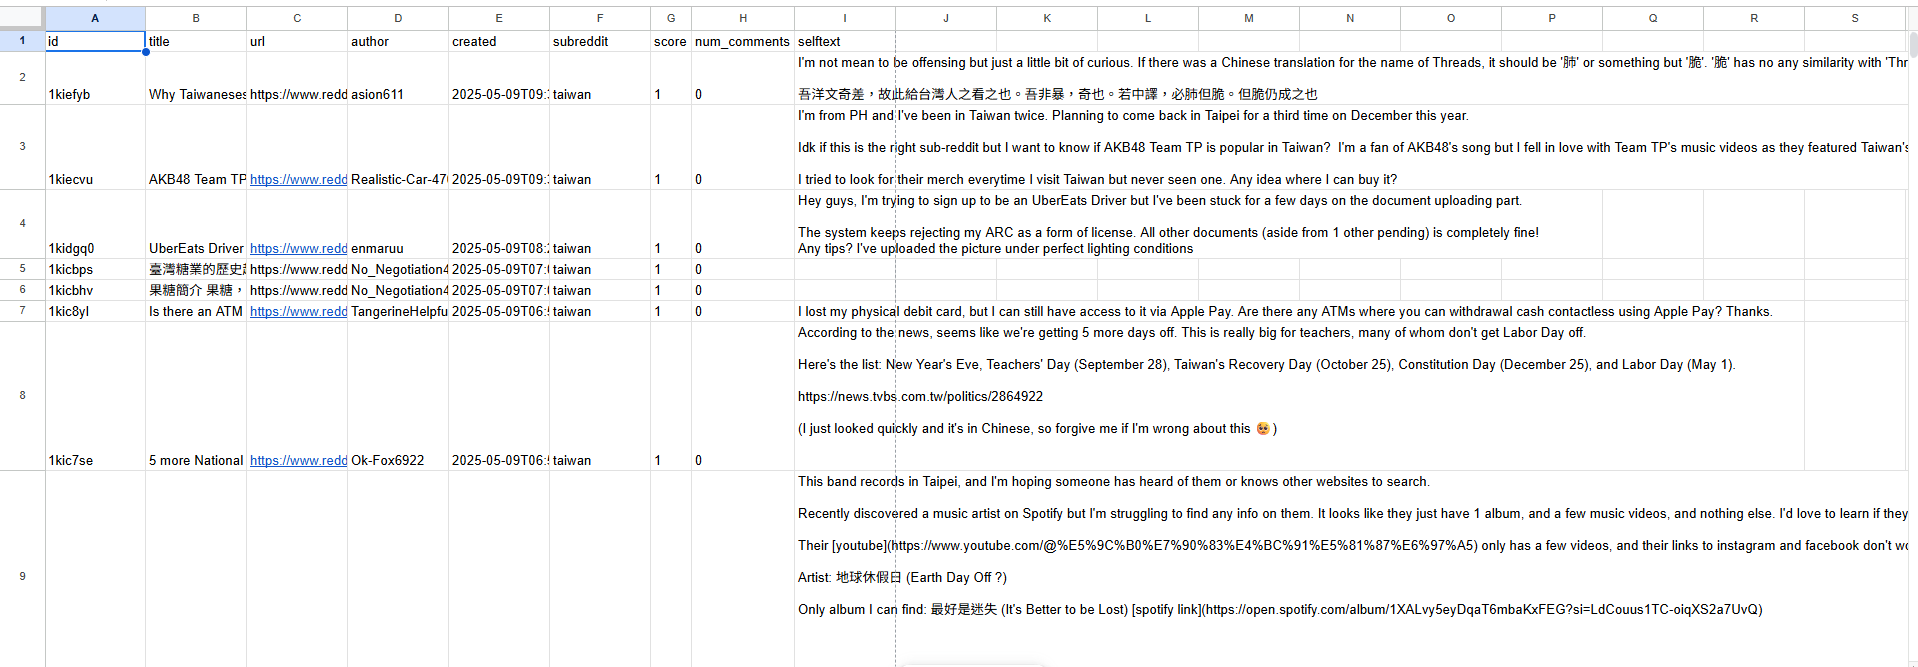